## Mask detection

###  Preprocessing 

In [1]:
# Importing required libraries

import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model


In [2]:
people = ['with_mask', 'without_mask']

In [3]:
IMAGE_SIZE = 256 
BATCH_SIZE = 16 
CHANNELS = 1
EPOCHS = 8

In [41]:
class BasicPreprocessing:
    
    def __init__(self):
        pass
    
    def import_dataset(self, DIR):
        features = []
        labels = []
        for person in people:
            path = os.path.join(DIR,person)
            label = person
            for img in os.listdir(path):
                img_path = os.path.join(path,img)
                img_array = cv.imread(img_path)
                features.append(img_array)
                labels.append(label)
        return features, labels
    
    def bgr_2_gray(self, images):
        for i in range(len(images)):
            img_array = images[i]
            images[i] = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
        return images
    
    def resize(self,features_resize,IMAGE_SIZE):
        for i in range(len(features_resize)):
            features_resize[i] = cv.resize(features_resize[i],(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv.INTER_CUBIC)
        return features_resize
    
    def normalize(self, feature_normalize):
        feature_normalize = np.array(feature_normalize)
        feature_normalize = feature_normalize/255.0
        return feature_normalize

    
    def cate_to_dummy(self,labels):
        le = LabelEncoder()
        labels = le.fit_transform(labels)
        return labels
    
    def reshape_data(self, images_normalized, IMAGE_SIZE):
        feature_reshaped = []
        for i in range(len(images_normalized)):
            feature_reshaped.append(images_normalized[i].reshape(IMAGE_SIZE,IMAGE_SIZE,1))
        return feature_reshaped
    
    def train_test(self,feature_reshape, labels, test_size, val_size):
        X,y= shuffle(feature_reshape,labels, random_state=1)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=1)
        return X_train, X_test, y_train, y_test,X_val, y_val
        
    
    def plot_sample(self, sample_size):
        plt.figure(figsize=(15,15))
        for i in range(sample_size):
            ax = plt.subplot(int(sample_size/4)+1,4,i+1)
            plt.imshow(X_test[i], cmap='gray')
            plt.title(people[y_test[i]])

In [42]:
bp = BasicPreprocessing()

In [29]:
images, labels = bp.import_dataset('data')

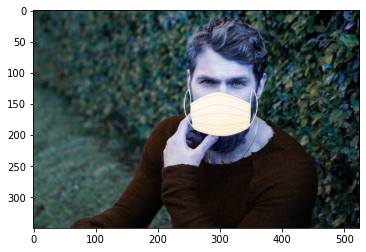

In [30]:
plt.imshow(images[0])

In [31]:
images_grey = bp.bgr_2_gray(images)

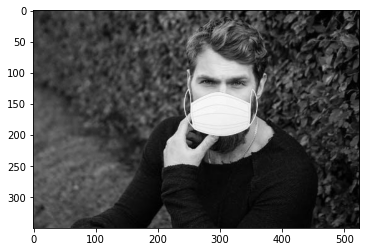

In [33]:
plt.imshow(images_grey[0],cmap='gray')

In [34]:
images_resized = bp.resize(images_grey, IMAGE_SIZE=IMAGE_SIZE)

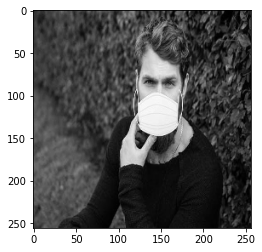

In [36]:
plt.imshow(images_resized[0],cmap='gray')

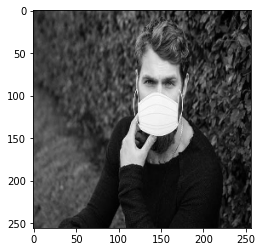

In [44]:
images_normalized = bp.normalize(images_resized)
plt.imshow(images_normalized[0],cmap='gray')

In [45]:
labels = bp.cate_to_dummy(labels)
labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [46]:
images_reshaped = bp.reshape_data(images_normalized, IMAGE_SIZE)

In [47]:
images_reshaped[0].shape

(256, 256, 1)

In [48]:
X_train, X_test, y_train, y_test,X_val, y_val = bp.train_test(images_reshaped,labels, test_size=0.2,val_size=0.1)
len(X_train),len(X_test), len(X_val), len(y_train),len(y_test),len(y_val)

(5437, 1511, 605, 5437, 1511, 605)

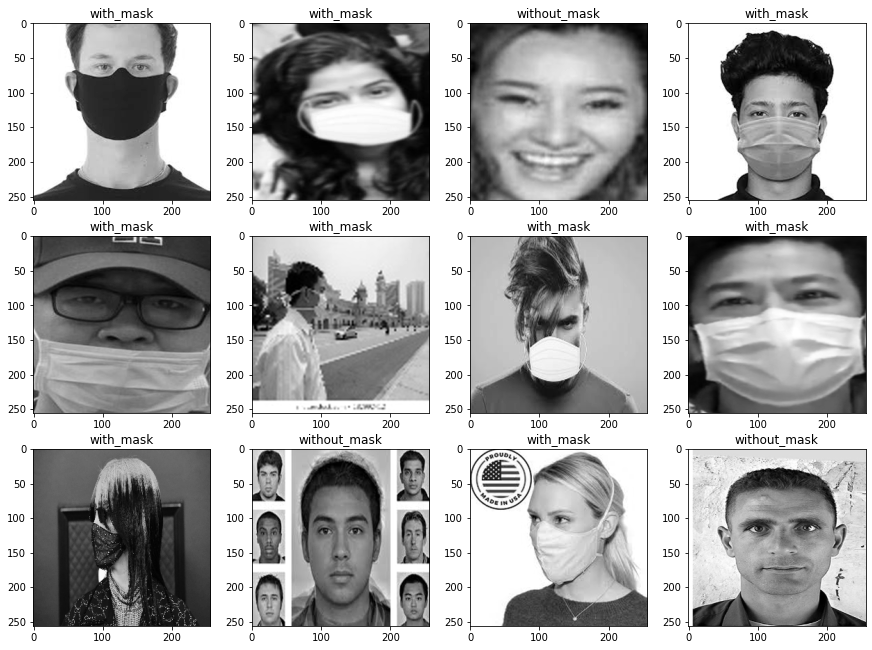

In [49]:
bp.plot_sample(12)

###  Model Development

In [18]:
class ModelDevelopment:
    
    def __init__(self):
        pass
    
    def extract_image_features(self):
        data_augmentation = tf.keras.Sequential([
            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            layers.experimental.preprocessing.RandomRotation(0.2)
        ])
        model = models.Sequential([
            data_augmentation,
            layers.Conv2D(filters=32, kernel_size=(3, 3),activation = 'relu', input_shape=(256, 256, 1)),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(filters=32, kernel_size=(3, 3),activation = 'relu', input_shape=(256, 256, 1)),
            layers.MaxPooling2D((2,2)),
            layers.Flatten(),
            layers.Dense(64,activation='relu'),
            layers.Dense(1,activation='sigmoid'),
        ])
        
        
        return model
    
    def train_model(self,models, X_train, y_train,X_val, y_val, epochs):
        models.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        model_history = models.fit(X_train, y_train, epochs=epochs,validation_data=(X_val, y_val))
        
        
        return model_history

    
    def test_model(self,model,X_test, y_test):
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        evaluation = model.evaluate(X_test,y_test)
        y_pred = model_new.predict(X_test)
        y_pred_classes = [1 if x >0.5 else 0 for x in y_pred]
        report = classification_report(y_test, y_pred_classes,zero_division=1)
        
        return (print(evaluation,'\n', report))

    def plot_graphs(self, model, epochs):
        plt.figure(figsize=(10,5))
        ax = plt.subplot(1,2,1)
        acc = model.history['accuracy'] #values of accuracy of each epoch
        val_acc = model.history['val_accuracy']
        plt.plot(range(epochs),acc, label ='Train Accuracy')
        plt.plot(range(epochs),val_acc, label = "validation accuracy")
        plt.legend()
        ax = plt.subplot(1,2,2)
        loss = model.history['loss'] #values of accuracy of each epoch
        val_loss = model.history['val_loss']
        plt.plot(range(epochs),loss, label ='Train loss')
        plt.plot(range(epochs),val_loss, label = "validation loss")
        plt.legend()

    # All other customized methods go under here
    
    def any_name(self):
        pass

In [19]:
md = ModelDevelopment()

In [20]:
model_new = md.extract_image_features()

In [21]:
model_history = md.train_model(model_new,X_train, y_train, X_val, y_val,epochs=20)

Epoch 1/20
170/170 [==============================] - 416s 2s/step - loss: 0.7093 - accuracy: 0.5481 - val_loss: 0.6560 - val_accuracy: 0.6231
Epoch 2/20
170/170 [==============================] - 304s 2s/step - loss: 0.6388 - accuracy: 0.6268 - val_loss: 0.6056 - val_accuracy: 0.6595
Epoch 3/20
170/170 [==============================] - 298s 2s/step - loss: 0.6102 - accuracy: 0.6586 - val_loss: 0.5626 - val_accuracy: 0.7223
Epoch 4/20
170/170 [==============================] - 295s 2s/step - loss: 0.5828 - accuracy: 0.6862 - val_loss: 0.5642 - val_accuracy: 0.6860
Epoch 5/20
170/170 [==============================] - 308s 2s/step - loss: 0.5651 - accuracy: 0.6991 - val_loss: 0.5407 - val_accuracy: 0.7174
Epoch 6/20
170/170 [==============================] - 299s 2s/step - loss: 0.5342 - accuracy: 0.7304 - val_loss: 0.4788 - val_accuracy: 0.7719
Epoch 7/20
170/170 [==============================] - 298s 2s/step - loss: 0.5000 - accuracy: 0.7603 - val_loss: 0.4944 - val_accuracy: 0.7554

In [22]:
md.test_model(model_new,X_test,y_test)

48/48 [==============================] - 26s 546ms/step - loss: 0.3895 - accuracy: 0.8266
[0.38945484161376953, 0.8266049027442932] 
               precision    recall  f1-score   support

           0       0.78      0.90      0.83       731
           1       0.89      0.76      0.82       780

    accuracy                           0.83      1511
   macro avg       0.83      0.83      0.83      1511
weighted avg       0.84      0.83      0.83      1511



In [23]:
model_new.save('model2.h5')

In [8]:
model_loaded = load_model('model1.h5')

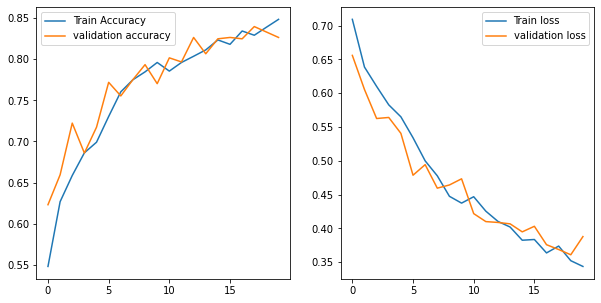

In [25]:
md.plot_graphs(model_history, 20)

###  Inference 

In [25]:
class BasicInference:
    
    def __init__(self):
        pass
    
    def detect_images(self,img_path, model):
        img_array = cv.imread(img_path)
        class_names = ['with_mask', 'without_mask']
        img_array = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
        img_array = cv.resize(img_array,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv.INTER_CUBIC)
        img_array = img_array/255.0
        img_array = img_array.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
        img_array = tf.expand_dims(img_array,0)
        predictions = model_loaded.predict(img_array)
        predicted_class = class_names[1 if predictions[0]>0.5 else 0]
        confidence = round(100*(np.max(predictions[0])),2)
        
        return f"Predicted Class is {predicted_class} with confidence {confidence}%"
    
    
    # All other customized methods go under here
    
    def Live_video_detection(self):
        class_names = ['with_mask', 'without_mask']
        face_classifier = cv.CascadeClassifier(cv.data.haarcascades +'haarcascade_frontalface_default.xml')
        eyes_classifier = cv.CascadeClassifier(cv.data.haarcascades +'haarcascade_eye.xml')

        def detect(gray, frame):
            faces = face_classifier.detectMultiScale(gray, 1.3, 5)
            for (x,y,w,h) in faces:
                cv.rectangle(frame, (x,y),(x+w,y+h),(127,0,255),2)#(127,0,255) - represents pink colour , (x,y)- starting position, (x+w,y+h) - height and width of rectangle
                roi_gray = gray[y:y+h, x:x+w]# this both lines help to crop the face
                roi_color = frame[y:y+h, x:x+w]
                eyes = eyes_classifier.detectMultiScale(roi_gray,1.1,3)

            return frame


        video_capture = cv.VideoCapture(0)
        while True:
            _, frame = video_capture.read()
            gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            img_array = cv.resize(gray,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv.INTER_CUBIC)
            img_array = img_array/255.0
            img_array = img_array.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
            img_array = tf.expand_dims(img_array,0)
            predictions = model_loaded.predict(img_array)
            predicted_class = class_names[1 if predictions[0]>0.5 else 0]
            confidence = round(100*(np.max(predictions[0])),2)
            canvas = detect(gray, frame)
            cv.putText(canvas,predicted_class,(250,50),cv.FONT_HERSHEY_COMPLEX, 1.0, (14, 234, 234), thickness =2)
            cv.imshow("video", canvas)
            if cv.waitKey(1)& 0xFF == ord('q'): 
                break
        video_capture.release()
        cv.destroyAllWindows()

In [26]:
bi = BasicInference()

In [27]:
bi.detect_images('data\without_mask\without_mask_2.jpg', model_loaded)

'Predicted Class is without_mask with confidence 86.35%'

In [28]:
bi.Live_video_detection()